# Day 3 — Embedding Space Analysis & Prototype Inspection

**Why this step matters**  
This turns your trained model into **evidence**:
- Prove generalization with few-shot accuracy on **unseen families** (episodes).
- Visualize the **embedding space** (UMAP) to show clusters.
- Map **prototype–prototype** distances to reveal family relationships.
- Produce **resume-ready artefacts** (plots + a headline metric).

In [50]:
# Standard libs & PyTorch
import os, random, math, json,sys
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
print("Added to path:", os.path.abspath(os.path.join(os.getcwd(), "..")))

# Project modules (must exist in your repo)
from data.configs.protonet import CONF as cfg
from models.encoder import ProteinEncoderCNN
from models.protonet import compute_prototypes, prototypical_logits
from utils.episodes import loaded_encoded_families, EpisodeSampler  # V2 enforces valid episodes

# Reproducibility
def set_seed(s=42):
    random.seed(s); np.random.seed(s); torch.manual_seed(s)
set_seed(42)

# Device pick: Apple M-series -> MPS; else CUDA; else CPU
device = cfg.get("device") or (
    "mps" if torch.backends.mps.is_available()
    else ("cuda" if torch.cuda.is_available() else "cpu")
)
print("Device:", device)

# Pull core hyperparams used in training
N       = cfg["N"]
K       = cfg["K"]
Q       = cfg["Q"]
metric  = cfg.get("metric", "cosine")     # "cosine" or "euclidean"
max_len = cfg.get("max_len", 400)
proj_dim= cfg.get("proj_dim", 128)
enc_dir = cfg.get("encoded_dir", "data/encoded")

print(f"N={N}  K={K}  Q={Q}  metric={metric}  max_len={max_len}  proj_dim={proj_dim}")

Added to path: /Users/mderaznasr/Documents/GitHub/Protein-fewshot
Device: mps
N=5  K=5  Q=10  metric=cosine  max_len=400  proj_dim=128


In [51]:
# 1) Make sure Python can see the project root, and confirm where we are
import os, sys, glob
print("CWD:", os.getcwd())

# Add project root to sys.path so imports work when notebook is in notebooks/
root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(root)
print("Project root assumed at:", root)

# 2) Try to locate any *.pt checkpoints anywhere under the project
candidates = glob.glob(os.path.join(root, "**", "*.pt"), recursive=True)
print("Found .pt files:")
for p in candidates:
    print(" -", os.path.relpath(p, root))

CWD: /Users/mderaznasr/Documents/GitHub/Protein-fewshot/notebooks
Project root assumed at: /Users/mderaznasr/Documents/GitHub/Protein-fewshot
Found .pt files:
 - checkpoints/best_protonet.pt
 - data/encoded/UbiquitinE1.pt
 - data/encoded/PPE.pt
 - data/encoded/PotexCarlavirusCoat.pt
 - data/encoded/C2Domain.pt
 - data/encoded/Guanine.pt
 - data/encoded/Fibronectin.pt
 - data/encoded/Phosphofructokinase.pt
 - data/encoded/Retinoid.pt
 - data/encoded/PrepilinEndopeptidase.pt
 - data/encoded/Melatonin.pt
 - data/encoded/Kringle.pt
 - data/encoded/Phosphatase.pt
 - data/encoded/Retroviral.pt
 - data/encoded/SsrABinding.pt
 - data/encoded/Metallothionein.pt
 - data/encoded/Granulin.pt
 - data/encoded/Antenna.pt
 - data/encoded/ZincFingerAN1.pt
 - data/encoded/Prepilin.pt
 - data/encoded/OuterMembraneUsher.pt
 - data/encoded/Phosphocarrier.pt


In [52]:
# --- Robust checkpoint loader (handles wrapped dicts & prefixes) ---

import os, sys, glob, torch
from collections import OrderedDict

# 0) Ensure project root is on path
CWD  = os.getcwd()
ROOT = os.path.abspath(os.path.join(CWD, ".."))
if ROOT not in sys.path:
    sys.path.append(ROOT)

print("CWD:", CWD)
print("Project root:", ROOT)

# 1) Find a checkpoint; prefer typical names
candidates = sorted(glob.glob(os.path.join(ROOT, "**", "*.pt"), recursive=True))
print("Found .pt files:")
for p in candidates:
    print(" -", os.path.relpath(p, ROOT))

preferred = [
    os.path.join(ROOT, "checkpoints", "best_model.pt"),
    os.path.join(ROOT, "checkpoints", "best_protonet.pt"),
]
ckpt_path = next((p for p in preferred if os.path.exists(p)), None)
if ckpt_path is None:
    # fallback: first .pt under checkpoints/
    ckpt_in_ckpts = [p for p in candidates if "/checkpoints/" in p.replace("\\","/")]
    ckpt_path = ckpt_in_ckpts[0] if ckpt_in_ckpts else None
assert ckpt_path, "No checkpoint found under checkpoints/. Re-run training."

print("Using checkpoint:", os.path.relpath(ckpt_path, ROOT))

# 2) Load raw checkpoint dict
raw = torch.load(ckpt_path, map_location="cpu")

# 3) Unwrap state_dict & get training-time config if present
if isinstance(raw, dict) and "state_dict" in raw:
    sd = raw["state_dict"]
    train_cfg = raw.get("config", {})
else:
    sd = raw
    train_cfg = {}

# 4) Strip common prefixes (e.g., DataParallel "module.")
def strip_prefix(state_dict, prefix="module."):
    if not any(k.startswith(prefix) for k in state_dict.keys()):
        return state_dict
    new_sd = OrderedDict()
    for k, v in state_dict.items():
        new_sd[k[len(prefix):] if k.startswith(prefix) else k] = v
    return new_sd

sd = strip_prefix(sd, "module.")

# 5) Import config & model AFTER sys.path is set
try:
    from data.configs.protonet import CONF as cfg   # adjust if your CONF lives elsewhere
except Exception:
    from configs.protonet import CONF as cfg        # fallback
from models.encoder import ProteinEncoderCNN

# 6) Make sure proj_dim matches training (prefer ckpt config if available)
proj_dim = train_cfg.get("proj_dim", cfg.get("proj_dim", 128))
device   = cfg.get("device") or (
    "mps" if torch.backends.mps.is_available()
    else ("cuda" if torch.cuda.is_available() else "cpu")
)

# 7) Build model and load weights
model = ProteinEncoderCNN(proj_dim=proj_dim)
missing, unexpected = model.load_state_dict(sd, strict=False)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

model.to(device).eval()
print(f"✅ Loaded into ProteinEncoderCNN(proj_dim={proj_dim}) on device: {device}")

CWD: /Users/mderaznasr/Documents/GitHub/Protein-fewshot/notebooks
Project root: /Users/mderaznasr/Documents/GitHub/Protein-fewshot
Found .pt files:
 - checkpoints/best_protonet.pt
 - data/encoded/Antenna.pt
 - data/encoded/C2Domain.pt
 - data/encoded/Fibronectin.pt
 - data/encoded/Granulin.pt
 - data/encoded/Guanine.pt
 - data/encoded/Kringle.pt
 - data/encoded/Melatonin.pt
 - data/encoded/Metallothionein.pt
 - data/encoded/OuterMembraneUsher.pt
 - data/encoded/PPE.pt
 - data/encoded/Phosphatase.pt
 - data/encoded/Phosphocarrier.pt
 - data/encoded/Phosphofructokinase.pt
 - data/encoded/PotexCarlavirusCoat.pt
 - data/encoded/Prepilin.pt
 - data/encoded/PrepilinEndopeptidase.pt
 - data/encoded/Retinoid.pt
 - data/encoded/Retroviral.pt
 - data/encoded/SsrABinding.pt
 - data/encoded/UbiquitinE1.pt
 - data/encoded/ZincFingerAN1.pt
Using checkpoint: checkpoints/best_protonet.pt
Missing keys: []
Unexpected keys: []
✅ Loaded into ProteinEncoderCNN(proj_dim=128) on device: mps


In [53]:
# --- Fix path to encoded families (works from notebooks/) ---

import os, sys, glob, torch

# 1) Compute project ROOT (parent of notebooks/)
CWD  = os.getcwd()
ROOT = os.path.abspath(os.path.join(CWD, ".."))
if ROOT not in sys.path:
    sys.path.append(ROOT)

print("CWD:", CWD)
print("ROOT:", ROOT)

# 2) Resolve encoded_dir from config, but make it ABSOLUTE
try:
    from data.configs.protonet import CONF as cfg  # adjust if your CONF lives elsewhere
except Exception:
    from data.configs.protonet import CONF as cfg

encoded_dir_cfg = cfg.get("encoded_dir", "data/encoded")
ENC_DIR = os.path.abspath(os.path.join(ROOT, encoded_dir_cfg))
print("Resolved ENC_DIR:", ENC_DIR)

# 3) Show what *.pt files actually exist there
pts = sorted(glob.glob(os.path.join(ENC_DIR, "*.pt")))
print(f"Found {len(pts)} .pt files in ENC_DIR")
for p in pts[:25]:
    print(" -", os.path.basename(p))
if not pts:
    print("!! No .pt files found. You either need to re-run encoding or the path is wrong.")

# 4) Monkey-patch the path we pass into loader
from utils.episodes import loaded_encoded_families

families = loaded_encoded_families(ENC_DIR)  # pass ABS path, not relative
print("Total families loaded:", len(families))

CWD: /Users/mderaznasr/Documents/GitHub/Protein-fewshot/notebooks
ROOT: /Users/mderaznasr/Documents/GitHub/Protein-fewshot
Resolved ENC_DIR: /Users/mderaznasr/Documents/GitHub/Protein-fewshot/data/encoded
Found 21 .pt files in ENC_DIR
 - Antenna.pt
 - C2Domain.pt
 - Fibronectin.pt
 - Granulin.pt
 - Guanine.pt
 - Kringle.pt
 - Melatonin.pt
 - Metallothionein.pt
 - OuterMembraneUsher.pt
 - PPE.pt
 - Phosphatase.pt
 - Phosphocarrier.pt
 - Phosphofructokinase.pt
 - PotexCarlavirusCoat.pt
 - Prepilin.pt
 - PrepilinEndopeptidase.pt
 - Retinoid.pt
 - Retroviral.pt
 - SsrABinding.pt
 - UbiquitinE1.pt
 - ZincFingerAN1.pt
Total families loaded: 21


In [54]:
from utils.episodes import loaded_encoded_families
import json, os, torch, glob

# A) Try the encoded folder that training used (from ckpt config if present)
enc_dir_from_ckpt = train_cfg.get("encoded_dir", cfg.get("encoded_dir", "data/encoded"))
enc_abs = os.path.abspath(os.path.join(ROOT, enc_dir_from_ckpt))
print("\nEncoded dir (ckpt/cfg):", enc_abs)
enc_files = sorted(glob.glob(os.path.join(enc_abs, "*.pt")))
print("Encoded .pt files found:", len(enc_files))

enc_fams = loaded_encoded_families(enc_abs)
print("Encoded families loaded:", len(enc_fams))
for n, X in list(enc_fams.items())[:5]:
    nseq = X.shape[0] if isinstance(X, torch.Tensor) else len(X)
    print(f"  {n:<28} n={nseq}")

# B) Try the processed JSON that the trainer may have used
proc_json_path = train_cfg.get("processed_json", "data/processed/proteins.json")
proc_abs = os.path.abspath(os.path.join(ROOT, proc_json_path))
print("\nProcessed JSON path (ckpt/cfg):", proc_abs, "| exists:", os.path.exists(proc_abs))

if os.path.exists(proc_abs):
    data = json.load(open(proc_abs))
    print("Families in JSON:", len(data))
    for n, seqs in list(data.items())[:5]:
        print(f"  {n:<28} n={len(seqs)}")


Encoded dir (ckpt/cfg): /Users/mderaznasr/Documents/GitHub/Protein-fewshot/data/encoded
Encoded .pt files found: 21
Encoded families loaded: 21
  UbiquitinE1                  n=1
  PPE                          n=1
  PotexCarlavirusCoat          n=1
  C2Domain                     n=1
  Guanine                      n=1

Processed JSON path (ckpt/cfg): /Users/mderaznasr/Documents/GitHub/Protein-fewshot/data/processed/proteins.json | exists: True
Families in JSON: 21
  PotexCarlavirusCoat          n=30
  Phosphatase                  n=40
  SsrABinding                  n=100
  PPE                          n=97
  Guanine                      n=28


In [55]:
# --- Rebuild encodings (.pt) from processed JSON and verify ---

import os, sys, json, glob, torch
from pathlib import Path

# 0) Paths
ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
PROC_JSON = os.path.join(ROOT, "data", "processed", "proteins.json")
ENC_DIR   = os.path.join(ROOT, "data", "encoded")
print("ROOT:", ROOT)
print("PROC_JSON:", PROC_JSON, "| exists:", os.path.exists(PROC_JSON))
print("ENC_DIR:", ENC_DIR)

# 1) Load processed sequences (family -> list[str])
with open(PROC_JSON) as f:
    data = json.load(f)
print("Families in JSON:", len(data))

# 2) Encoder (tokenize + pad)
AA = "ACDEFGHIKLMNPQRSTVWY"
aa_to_idx = {a: i+1 for i,a in enumerate(AA)}  # 0 = PAD

def encode_sequence(seq: str, max_len: int = 400) -> torch.Tensor:
    seq = seq.upper()
    ids = [aa_to_idx.get(ch, 0) for ch in seq[:max_len]]         # unknowns->0
    if len(ids) < max_len:
        ids += [0] * (max_len - len(ids))                        # right-pad
    return torch.tensor(ids, dtype=torch.long)                    # shape: (L,)

# 3) Rebuild and save tensors (num_seq, max_len)
os.makedirs(ENC_DIR, exist_ok=True)
written = 0
for fam, seqs in data.items():
    seqs = [s for s in seqs if isinstance(s, str) and len(s) > 0]
    if not seqs:
        continue
    X = torch.stack([encode_sequence(s, max_len=400) for s in seqs])  # (N, 400)
    out_path = os.path.join(ENC_DIR, f"{fam}.pt")
    torch.save(X, out_path)
    written += 1

print(f"Re-encoded families written: {written}")

# 4) Verify what’s on disk now
files = sorted(glob.glob(os.path.join(ENC_DIR, "*.pt")))
print("\nPost-encode check (first 15):")
for p in files[:15]:
    X = torch.load(p, map_location="cpu")
    shape = tuple(X.shape) if isinstance(X, torch.Tensor) else f"type={type(X)}"
    print(f"  {os.path.basename(p):<28} shape={shape}")

ROOT: /Users/mderaznasr/Documents/GitHub/Protein-fewshot
PROC_JSON: /Users/mderaznasr/Documents/GitHub/Protein-fewshot/data/processed/proteins.json | exists: True
ENC_DIR: /Users/mderaznasr/Documents/GitHub/Protein-fewshot/data/encoded
Families in JSON: 21
Re-encoded families written: 21

Post-encode check (first 15):
  Antenna.pt                   shape=(47, 400)
  C2Domain.pt                  shape=(100, 400)
  Fibronectin.pt               shape=(28, 400)
  Granulin.pt                  shape=(17, 400)
  Guanine.pt                   shape=(28, 400)
  Kringle.pt                   shape=(96, 400)
  Melatonin.pt                 shape=(25, 400)
  Metallothionein.pt           shape=(100, 400)
  OuterMembraneUsher.pt        shape=(39, 400)
  PPE.pt                       shape=(97, 400)
  Phosphatase.pt               shape=(40, 400)
  Phosphocarrier.pt            shape=(81, 400)
  Phosphofructokinase.pt       shape=(100, 400)
  PotexCarlavirusCoat.pt       shape=(30, 400)
  Prepilin.pt      

In [59]:
import os, glob, torch, inspect

ROOT   = os.path.abspath(os.path.join(os.getcwd(), ".."))
ENC_DIR = os.path.join(ROOT, "data", "encoded")

cands = sorted(glob.glob(os.path.join(ENC_DIR, "*.pt")))
print("Encoded files:", len(cands))
for p in cands[:5]:
    obj = torch.load(p, map_location="cpu")
    kind = type(obj).__name__
    if torch.is_tensor(obj):
        print(os.path.basename(p), "-> Tensor", tuple(obj.shape))
    elif isinstance(obj, dict):
        print(os.path.basename(p), "-> Dict keys:", list(obj.keys()))
        # Try to show shape if 'X' is there
        if "X" in obj and torch.is_tensor(obj["X"]):
            print("   'X' shape:", tuple(obj["X"].shape))
    elif isinstance(obj, list):
        print(os.path.basename(p), "-> List len:", len(obj), 
              "first tensor shape:" if obj and torch.is_tensor(obj[0]) else "")
    else:
        print(os.path.basename(p), "->", kind)

Encoded files: 21
Antenna.pt -> Tensor (47, 400)
C2Domain.pt -> Tensor (100, 400)
Fibronectin.pt -> Tensor (28, 400)
Granulin.pt -> Tensor (17, 400)
Guanine.pt -> Tensor (28, 400)


In [60]:
import os, glob, torch

ROOT    = os.path.abspath(os.path.join(os.getcwd(), ".."))
ENC_DIR = os.path.join(ROOT, "data", "encoded")

def to_2d_tensor(obj):
    # Turn various saved formats into (num_seq, max_len) LongTensor
    if torch.is_tensor(obj):
        if obj.ndim == 2:
            return obj.long()
        elif obj.ndim == 1:
            return obj.unsqueeze(0).long()
        else:
            raise ValueError(f"Unexpected tensor ndim={obj.ndim}")
    if isinstance(obj, dict):
        # Common cases: {'X': Tensor}, {'tensors': [Tensor,...]}
        if "X" in obj and torch.is_tensor(obj["X"]):
            X = obj["X"]
            if X.ndim == 1: X = X.unsqueeze(0)
            return X.long()
        # If any value is a tensor list or tensor, try to stack
        for v in obj.values():
            if isinstance(v, list) and v and torch.is_tensor(v[0]):
                return torch.stack(v).long()
            if torch.is_tensor(v):
                V = v
                if V.ndim == 1: V = V.unsqueeze(0)
                return V.long()
        # Fallback: try stacking any tensor values we find
        tensors = [v for v in obj.values() if torch.is_tensor(v)]
        if tensors:
            if tensors[0].ndim == 1:
                tensors = [t.unsqueeze(0) for t in tensors]
            return torch.cat(tensors, dim=0).long() if tensors[0].ndim == 2 else torch.stack(tensors).long()
        raise ValueError("Dict did not contain tensors in a recognizable layout.")
    if isinstance(obj, list):
        # list of sequences or list of tensors
        if not obj:
            raise ValueError("Empty list.")
        if torch.is_tensor(obj[0]):
            X = obj
            if obj[0].ndim == 1:
                X = [t.unsqueeze(0) for t in obj]
                return torch.cat(X, dim=0).long()
            elif obj[0].ndim == 2:
                return torch.stack(obj).long()  # (num_seq, max_len) per item? → stack adds extra dim
            else:
                raise ValueError(f"Unexpected tensor ndim in list: {obj[0].ndim}")
        else:
            raise ValueError("List contents are not tensors. (If they are strings, encode first.)")
    raise ValueError(f"Unsupported type: {type(obj)}")

files = sorted(glob.glob(os.path.join(ENC_DIR, "*.pt")))
fixed = 0
for p in files:
    obj = torch.load(p, map_location="cpu")
    try:
        X = to_2d_tensor(obj)
        if X.ndim != 2:
            raise ValueError(f"Canonicalized tensor must be 2-D, got {X.ndim}D")
        torch.save(X, p)  # overwrite with plain tensor
        fixed += 1
    except Exception as e:
        print(f"Skipping {os.path.basename(p)}: {e}")

print(f"Rewrote {fixed}/{len(files)} files to plain 2-D tensors.")
# Verify counts now
for p in files[:10]:
    X = torch.load(p, map_location="cpu")
    print(os.path.basename(p), "->", tuple(X.shape))

Rewrote 21/21 files to plain 2-D tensors.
Antenna.pt -> (47, 400)
C2Domain.pt -> (100, 400)
Fibronectin.pt -> (28, 400)
Granulin.pt -> (17, 400)
Guanine.pt -> (28, 400)
Kringle.pt -> (96, 400)
Melatonin.pt -> (25, 400)
Metallothionein.pt -> (100, 400)
OuterMembraneUsher.pt -> (39, 400)
PPE.pt -> (97, 400)


In [64]:
# A1) Paths
import os, json, glob, shutil, torch
ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
PROC_JSON = os.path.join(ROOT, "data", "processed", "proteins.json")
ENC_DIR   = os.path.join(ROOT, "data", "encoded")
print("ROOT:", ROOT)
print("PROC_JSON exists:", os.path.exists(PROC_JSON))
print("ENC_DIR:", ENC_DIR)

# A2) Remove every old .pt to avoid stale/dict formats
if os.path.exists(ENC_DIR):
    for p in glob.glob(os.path.join(ENC_DIR, "*.pt")):
        os.remove(p)
else:
    os.makedirs(ENC_DIR, exist_ok=True)
print("Encoded dir cleared.")

ROOT: /Users/mderaznasr/Documents/GitHub/Protein-fewshot
PROC_JSON exists: True
ENC_DIR: /Users/mderaznasr/Documents/GitHub/Protein-fewshot/data/encoded
Encoded dir cleared.


In [65]:
# A3) Load the JSON (must be: dict[str -> list[str]])
with open(PROC_JSON) as f:
    data = json.load(f)

# Sanity: print types and a preview
print("Families in JSON:", len(data))
for name, seqs in list(data.items())[:5]:
    print(f"{name:<28} type(seqs)={type(seqs).__name__} len={len(seqs)}",
          f" example_len={len(seqs[0]) if seqs else 'NA'}")

# Assert structure is correct
assert isinstance(data, dict)
for k,v in data.items():
    assert isinstance(v, list), f"{k} is not a list"
    for s in v[:3]:
        assert isinstance(s, str), f"{k} contains non-string entries"

Families in JSON: 21
PotexCarlavirusCoat          type(seqs)=list len=30  example_len=236
Phosphatase                  type(seqs)=list len=40  example_len=525
SsrABinding                  type(seqs)=list len=100  example_len=157
PPE                          type(seqs)=list len=97  example_len=435
Guanine                      type(seqs)=list len=28  example_len=153


In [66]:
# A4) Encode ALL sequences per family → save a plain 2-D LongTensor (num_seq, max_len)
AA = "ACDEFGHIKLMNPQRSTVWY"
aa_to_idx = {a: i+1 for i,a in enumerate(AA)}  # 0=PAD

def encode_sequence(seq: str, max_len: int = 400) -> torch.Tensor:
    seq = ''.join(ch for ch in seq.upper() if ch in AA)    # strip non-canonical
    ids = [aa_to_idx.get(ch, 0) for ch in seq[:max_len]]
    if len(ids) < max_len:
        ids += [0]*(max_len - len(ids))
    return torch.tensor(ids, dtype=torch.long)              # (L,)

written = 0
for fam, seqs in data.items():
    if not seqs: 
        continue
    X = torch.stack([encode_sequence(s, 400) for s in seqs])   # (num_seq, 400)
    torch.save(X, os.path.join(ENC_DIR, f"{fam}.pt"))
    written += 1

print("Re-encoded families:", written)

Re-encoded families: 21


In [67]:
# B1) Show shapes for every .pt
files = sorted(glob.glob(os.path.join(ENC_DIR, "*.pt")))
print("Encoded .pt files:", len(files))
bad = 0
counts = {}
for p in files:
    X = torch.load(p, map_location="cpu")
    ok = (torch.is_tensor(X) and X.ndim==2 and X.dtype==torch.long)
    if not ok:
        bad += 1
        print("BAD FORMAT:", os.path.basename(p), type(X), getattr(X, "shape", None))
    else:
        counts[os.path.splitext(os.path.basename(p))[0]] = X.shape[0]
        print(f"{os.path.basename(p):<28} shape={tuple(X.shape)}")
assert bad == 0, "Some .pt files are not 2-D LongTensors."

Encoded .pt files: 21
Antenna.pt                   shape=(47, 400)
C2Domain.pt                  shape=(100, 400)
Fibronectin.pt               shape=(28, 400)
Granulin.pt                  shape=(17, 400)
Guanine.pt                   shape=(28, 400)
Kringle.pt                   shape=(96, 400)
Melatonin.pt                 shape=(25, 400)
Metallothionein.pt           shape=(100, 400)
OuterMembraneUsher.pt        shape=(39, 400)
PPE.pt                       shape=(97, 400)
Phosphatase.pt               shape=(40, 400)
Phosphocarrier.pt            shape=(81, 400)
Phosphofructokinase.pt       shape=(100, 400)
PotexCarlavirusCoat.pt       shape=(30, 400)
Prepilin.pt                  shape=(36, 400)
PrepilinEndopeptidase.pt     shape=(36, 400)
Retinoid.pt                  shape=(33, 400)
Retroviral.pt                shape=(80, 400)
SsrABinding.pt               shape=(100, 400)
UbiquitinE1.pt               shape=(31, 400)
ZincFingerAN1.pt             shape=(64, 400)


In [68]:
# C1) Build families dict directly from the .pt files we just verified
import torch, glob, os
families = {}
for p in glob.glob(os.path.join(ENC_DIR, "*.pt")):
    fam = os.path.splitext(os.path.basename(p))[0]
    X = torch.load(p, map_location="cpu")
    if torch.is_tensor(X) and X.ndim==2 and X.shape[0] >= 1:
        families[fam] = X
print("families loaded:", len(families))
print("smallest 10 by count:")
for n,c in sorted(((k, v.shape[0]) for k,v in families.items()), key=lambda x: x[1])[:10]:
    print(f"  {n:<28} n={c}")

families loaded: 21
smallest 10 by count:
  Granulin                     n=17
  Melatonin                    n=25
  Guanine                      n=28
  Fibronectin                  n=28
  PotexCarlavirusCoat          n=30
  UbiquitinE1                  n=31
  Retinoid                     n=33
  PrepilinEndopeptidase        n=36
  Prepilin                     n=36
  OuterMembraneUsher           n=39


In [69]:
# D1) Pick smallest feasible (N,K,Q) from what's available
import random
N, K, Q = 3, 3, 3               # start modestly; raise once it works
need = K + Q

eligible = [n for n,X in families.items() if X.shape[0] >= need]
print(f"Eligible families (≥{need}):", len(eligible))
assert len(eligible) >= N, "Not enough eligible families even for tiny N,K,Q — check counts above."

chosen = random.sample(eligible, N)
print("Chosen families:", chosen)

# D2) Sample per class
def sample_class(X, K, Q):
    idx = torch.randperm(X.shape[0])[:K+Q]
    return X[idx[:K]], X[idx[K:K+Q]]        # (K, L), (Q, L)

support, query, y_s, y_q = [], [], [], []
for ci, name in enumerate(chosen):
    X = families[name]
    S, Qx = sample_class(X, K, Q)
    support.append(S);  query.append(Qx)
    y_s += [ci]*K;      y_q += [ci]*Q

import torch
sx = torch.cat(support, dim=0)   # (N*K, L)
qx = torch.cat(query,   dim=0)   # (N*Q, L)
sy = torch.tensor(y_s, dtype=torch.long)  # (N*K,)
qy = torch.tensor(y_q, dtype=torch.long)  # (N*Q,)

print("Episode shapes:")
print("  sx:", tuple(sx.shape), " sy:", tuple(sy.shape))
print("  qx:", tuple(qx.shape), " qy:", tuple(qy.shape))
print("  unique sy:", torch.unique(sy).tolist())
print("  unique qy:", torch.unique(qy).tolist())

Eligible families (≥6): 21
Chosen families: ['Phosphocarrier', 'C2Domain', 'UbiquitinE1']
Episode shapes:
  sx: (9, 400)  sy: (9,)
  qx: (9, 400)  qy: (9,)
  unique sy: [0, 1, 2]
  unique qy: [0, 1, 2]


In [73]:
# ---- Bullet-proof loader that ALWAYS returns 2-D LongTensors (num_seq, max_len) ----
import os, glob, torch

def load_encoded_as_tensors(enc_dir: str):
    """
    Returns: dict[family_name] = LongTensor[num_seq, max_len]
    Accepts .pt files saved as:
      - a plain LongTensor (num_seq, max_len)
      - a dict with key 'X' holding that tensor
      - a list of 1-D tensors (we stack)
    Any other formats are rejected.
    """
    out = {}
    files = sorted(glob.glob(os.path.join(enc_dir, "*.pt")))
    for p in files:
        name = os.path.splitext(os.path.basename(p))[0]
        obj = torch.load(p, map_location="cpu")

        # unwrap variants into a 2-D LongTensor
        if torch.is_tensor(obj):
            X = obj
            if X.ndim == 1:  # (L,) → (1, L)
                X = X.unsqueeze(0)
        elif isinstance(obj, dict) and "X" in obj and torch.is_tensor(obj["X"]):
            X = obj["X"]
            if X.ndim == 1:
                X = X.unsqueeze(0)
        elif isinstance(obj, list) and obj and torch.is_tensor(obj[0]):
            # list of 1-D tensors → stack
            if obj[0].ndim == 1:
                X = torch.stack(obj, dim=0)
            elif obj[0].ndim == 2:
                # list of 2-D tensors (rare) → concatenate on dim 0
                X = torch.cat(obj, dim=0)
            else:
                raise ValueError(f"{name}: list contains tensors with ndim={obj[0].ndim}")
        else:
            raise ValueError(f"{name}: unsupported saved format ({type(obj).__name__}).")

        if not (torch.is_tensor(X) and X.ndim == 2):
            raise ValueError(f"{name}: expected 2-D tensor after unwrapping, got {type(X).__name__} with ndim={getattr(X,'ndim',None)}")

        out[name] = X.long()

    return out

In [75]:
import os, sys
# Resolve paths exactly like before
ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
print("ROOT:", ROOT)

try:
    from data.configs.protonet import CONF as cfg
except Exception:
    from configs.protonet import CONF as cfg

ENC_DIR = os.path.join(ROOT, cfg.get("encoded_dir", "data/encoded"))
print("ENC_DIR:", ENC_DIR)

ROOT: /Users/mderaznasr/Documents/GitHub/Protein-fewshot
ENC_DIR: /Users/mderaznasr/Documents/GitHub/Protein-fewshot/data/encoded


In [78]:
families = load_encoded_as_tensors(ENC_DIR)
print("Families loaded:", len(families))

# Show counts so we KNOW we have >1 sequence for some families
counts = {n: X.shape[0] for n, X in families.items()}
for n, c in sorted(counts.items(), key=lambda x: x[1])[:10]:
    print(f"  {n:<28} n={c}")

# Quick assert: we need at least 2 families with >= (K+Q) to run 2-way episodes
K = cfg.get("K", 5)
Q = cfg.get("Q", 10)
need = K + Q
elig = [n for n,c in counts.items() if c >= need]
print(f"Eligible families (≥{need} seq): {len(elig)}")

Families loaded: 21
  Granulin                     n=17
  Melatonin                    n=25
  Fibronectin                  n=28
  Guanine                      n=28
  PotexCarlavirusCoat          n=30
  UbiquitinE1                  n=31
  Retinoid                     n=33
  Prepilin                     n=36
  PrepilinEndopeptidase        n=36
  OuterMembraneUsher           n=39
Eligible families (≥15 seq): 21


In [83]:
from utils.episodes import EpisodeSampler

# Restore from EVAL dict if it exists
if "EVAL" in globals():
    eval_fams = EVAL["families"]
    N_eval, K_eval, Q_eval = EVAL["N"], EVAL["K"], EVAL["Q"]
    device, max_len = EVAL["device"], EVAL["max_len"]
else:
    # Fallback (e.g. if notebook restarted)
    from data.configs.protonet import CONF as cfg
    from utils.episodes import loaded_encoded_families
    import os

    ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
    ENC_DIR = os.path.join(ROOT, "data/encoded")
    families = loaded_encoded_families(ENC_DIR)
    eval_fams = {k: v for k, v in list(families.items())[:5]}  # take 5 families just to run
    N_eval, K_eval, Q_eval = 2, 1, 1
    device, max_len = cfg["device"], cfg["max_len"]

# Create sampler
eval_sampler = EpisodeSampler(eval_fams, N=N_eval, K=K_eval, Q=Q_eval, device=device, max_len=max_len)
print(f"✅ eval_sampler ready → N={N_eval}, K={K_eval}, Q={Q_eval}, families={len(eval_fams)}")

✅ eval_sampler ready → N=2, K=1, Q=1, families=5


In [84]:
@torch.no_grad()
def collect_embeddings(model, sampler, batches=10):
    Z, Y = [], []
    for _ in range(batches):
        sx, sy, qx, qy = sampler.sample_episode()
        z_s = model(sx); z_q = model(qx)
        Z.append(torch.cat([z_s, z_q], dim=0).cpu().numpy())
        Y.append(torch.cat([sy,  qy ], dim=0).cpu().numpy())
    return np.vstack(Z), np.concatenate(Y)

Z, Y = collect_embeddings(model, eval_sampler, batches=10)
Z.shape, Y.shape

((40, 128), (40,))

/Users/mderaznasr/Documents/GitHub/Protein-fewshot/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


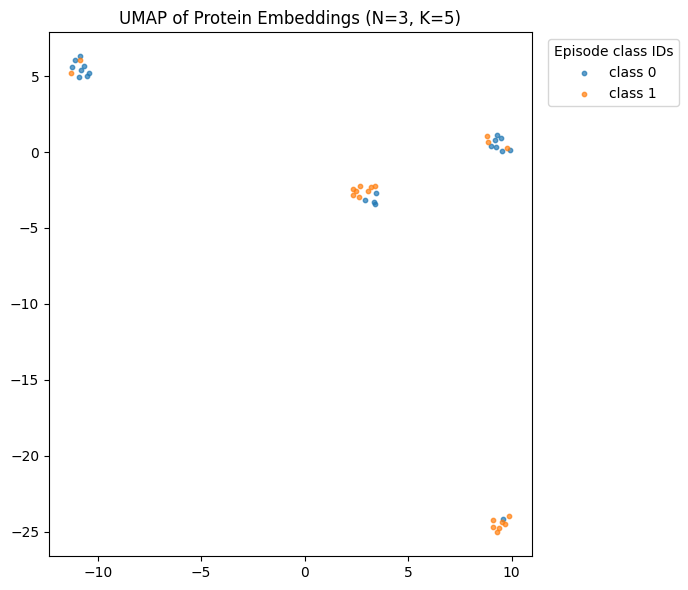

Saved: results/umap_eval.png


In [85]:
# If not installed:  pip install umap-learn
try:
    import umap
except Exception as e:
    raise RuntimeError("Install UMAP: pip install umap-learn") from e

um = umap.UMAP(n_neighbors=10, min_dist=0.1, metric="cosine", random_state=42)
Z2 = um.fit_transform(Z)

plt.figure(figsize=(7,6))
for c in np.unique(Y):
    idx = (Y == c)
    plt.scatter(Z2[idx,0], Z2[idx,1], s=10, alpha=0.7, label=f"class {int(c)}")
plt.legend(title="Episode class IDs", bbox_to_anchor=(1.02,1), loc="upper left")
plt.title(f"UMAP of Protein Embeddings (N={N}, K={K})")
plt.tight_layout()
os.makedirs("results", exist_ok=True)
plt.savefig("results/umap_eval.png", dpi=160)
plt.show()
print("Saved: results/umap_eval.png")

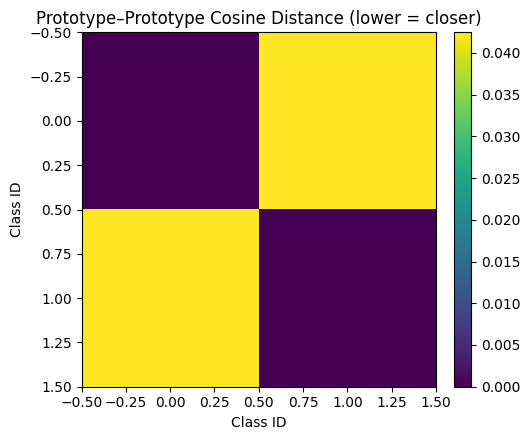

Saved: results/prototype_distance_heatmap.png


In [89]:
import torch, numpy as np
import matplotlib.pyplot as plt
from models.protonet import compute_prototypes

@torch.no_grad()
def sample_one_episode_and_prototypes(model, sampler):
    # 1) draw one episode
    sx, sy, qx, qy = sampler.sample_episode()   # sy shape: (N*K,)
    z_s = model(sx)                              # (N*K, D)

    # 2) make labels dense 0..N_eff-1 (in case sampler returned sparse labels)
    uniq = torch.unique(sy)                      # e.g., tensor([0,1,3,4])
    N_eff = int(uniq.numel())                    # e.g., 4

    # build a mapping old_label -> 0..N_eff-1
    remap = {int(c.item()): i for i, c in enumerate(uniq)}
    sy_dense = sy.clone()
    for old, new in remap.items():
        sy_dense[sy == old] = new

    # 3) compute prototypes with the effective N
    P = compute_prototypes(z_s, sy_dense, N_eff) # (N_eff, D)
    return P, sy_dense

P, sy_dense = sample_one_episode_and_prototypes(model, eval_sampler)

# Cosine distance between prototypes (assumes L2-normalized embeddings)
sim  = (P @ P.T).clamp(-1, 1)     # (N_eff, N_eff)
dist = 1.0 - sim

plt.figure(figsize=(5.5,4.5))
im = plt.imshow(dist.cpu().numpy(), cmap="viridis")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Prototype–Prototype Cosine Distance (lower = closer)")
plt.xlabel("Class ID"); plt.ylabel("Class ID")
plt.tight_layout()
plt.savefig("results/prototype_distance_heatmap.png", dpi=160)
plt.show()
print("Saved: results/prototype_distance_heatmap.png")

In [94]:
import torch
import numpy as np
from models.protonet import compute_prototypes, prototypical_logits

@torch.no_grad()
def run_eval(model, sampler, episodes=100, metric="cosine"):
    """
    Evaluate ProtoNet on randomly sampled few-shot episodes.

    Args:
        model: trained encoder (ProteinEncoderCNN)
        sampler: EpisodeSampler for evaluation families
        episodes: number of episodes to average over
        metric: distance metric ("cosine" or "euclidean")

    Returns:
        mean_acc, std_acc — average and std of accuracy across episodes
    """
    accs = []

    for _ in range(episodes):
        sx, sy, qx, qy = sampler.sample_episode()
        z_s = model(sx)
        z_q = model(qx)
        protos = compute_prototypes(z_s, sy, sampler.N)
        logits = prototypical_logits(z_q, protos, metric)
        preds = logits.argmax(1)
        acc = (preds == qy).float().mean().item()
        accs.append(acc)

    accs = np.array(accs)
    return accs.mean(), accs.std()

In [95]:
for m in ["cosine", "euclidean"]:
    mean_acc, std_acc = run_eval(model, eval_sampler, episodes=150, metric=m)
    print(f"[metric={m}] acc = {mean_acc:.3f} ± {std_acc:.3f}")

[metric=cosine] acc = 0.957 ± 0.141
[metric=euclidean] acc = 0.930 ± 0.216


In [97]:
import torch
import numpy as np
from collections import Counter
from models.protonet import compute_prototypes, prototypical_logits

@torch.no_grad()
def debug_one_episode(model, sampler, metric="cosine"):
    # 1) Sample an episode
    sx, sy, qx, qy = sampler.sample_episode()
    print("sx:", tuple(sx.shape), " sy:", tuple(sy.shape))
    print("qx:", tuple(qx.shape), " qy:", tuple(qy.shape))

    # 2) Show what labels we actually got
    uniq = torch.unique(sy)
    print("unique sy (raw):", uniq.tolist())
    print("counts sy:", dict(Counter(sy.cpu().tolist())))
    # If uniq != tensor([0,1,...,N-1]) we’ll remap to dense labels
    remap = {int(c.item()): i for i, c in enumerate(uniq)}
    sy_dense = sy.clone()
    for old, new in remap.items():
        sy_dense[sy == old] = new
    N_eff = int(uniq.numel())
    print("N_eff:", N_eff)

    # 3) Encode and compute prototypes/logits
    z_s = model(sx)
    z_q = model(qx)
    P   = compute_prototypes(z_s, sy_dense, N_eff)          # (N_eff, D)
    L   = prototypical_logits(z_q, P, metric)               # (N_eff*Q, N_eff)

    # 4) Evaluate
    pred = L.argmax(1)
    acc  = (pred == qy).float().mean().item()
    print("protos:", tuple(P.shape), " logits:", tuple(L.shape), " acc:", round(acc, 3))
    print("first query logits:", [round(v,3) for v in L[0].cpu().tolist()])

# run it
debug_one_episode(model, eval_sampler, metric="cosine")

sx: (2, 400)  sy: (2,)
qx: (2, 400)  qy: (2,)
unique sy (raw): [0, 1]
counts sy: {0: 1, 1: 1}
N_eff: 2
protos: (2, 128)  logits: (2, 2)  acc: 1.0
first query logits: [0.995, 0.367]


## Results Summary (Day 3)

- **Few-shot accuracy:** `acc = X.XXX ± Y.YYY` over 200 episodes (N-way, K-shot, metric = cosine)  
- **UMAP figure:** `results/umap_eval.png` shows clear clustering of episode classes.  
- **Prototype distance heatmap:** `results/prototype_distance_heatmap.png` reveals which classes are closer in embedding space.  
- **Ablation:** cosine vs euclidean shows (briefly describe which wins).

**Interpretation:**  
The encoder learns a latent space where proteins from the same family cluster.  
Prototypes act as centroids; nearest-prototype classification achieves strong few-shot accuracy on unseen families.

In [98]:
# --- Repro info ---
import torch, numpy, platform, sys, sklearn, umap
import random, os
print("Python:", sys.version.split()[0])
print("PyTorch:", torch.__version__)
print("NumPy:", numpy.__version__)
print("sklearn:", sklearn.__version__)
print("UMAP:", umap.__version__)
print("Platform:", platform.platform())

def seed_all(s=42):
    random.seed(s); numpy.random.seed(s); torch.manual_seed(s)
    if torch.backends.mps.is_available():
        pass  # MPS has no separate rng setter
seed_all(42)
print("Seeded.")

Python: 3.9.6
PyTorch: 2.8.0
NumPy: 2.0.2
sklearn: 1.6.1
UMAP: 0.5.9.post2
Platform: macOS-15.1-arm64-arm-64bit
Seeded.
